In [1]:
# Training the model on 30k datasets.
# Before training add "env": {"PYTHONHASHSEED":"0"} to kernel.json file
# Use `jupyter kernelspec list` to see a list of installed kernels
# For more info see: 
# https://stackoverflow.com/questions/58067359/is-there-a-way-to-set-pythonhashseed-for-a-jupyter-notebook-session

import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve

from constants import experiment_set, protein_list, protein_names
from utils import get_class, get_model, load_data_sources, reset_seeds

# Set random seeds for reproducibility.

reset_seeds()

# When running on a GPU, some operations have non-deterministic outputs.
# Force the code to run on a single core of the CPU.
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3

In [2]:
# TRAIN
average_score = np.zeros(len(protein_list))

for training_set_number in range(3):
    reset_seeds()
    score_list = []

    if not os.path.exists("results/set_%s" % training_set_number):
        os.makedirs("results/set_%s" % training_set_number)

    for protein in protein_list:
        reset_seeds()

        if not os.path.exists("results/set_%s/%s" % (training_set_number, protein)):
            os.makedirs("results/set_%s/%s" % (training_set_number, protein))

        print(protein)

        data_sources, X = load_data_sources(
            protein, "train", training_set_number, *experiment_set
        )
        y = get_class(protein, "train", training_set_number)
        size = X.shape[2]
        score = []

        model = get_model(size)

        model.compile(
            loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
        )

        checkpointer = ModelCheckpoint(
            filepath="models/" + protein + "_weights.hdf5",
            verbose=2,
            save_best_only=True,
        )
        earlystopper = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
        metrics = model.fit(
            X,
            y,
            validation_split=0.2,
            epochs=12,
            batch_size=200,
            verbose=1,
            callbacks=[earlystopper],
            #shuffle=False,
        )

        # Save score list
        with open(
            "results/set_%s/%s/score" % (training_set_number, protein), "w"
        ) as score_file:
            np.save(("results/set_%s/%s/score" % (training_set_number, protein)), score)

        # Save model and weights to .json file.
        json_model = model.to_json()
        with open(
            "results/set_%s/%s/model.json" % (training_set_number, protein), "w"
        ) as json_file:
            json_file.write(json_model)
        with open(
            "results/set_%s/%s/weights.h5" % (training_set_number, protein), "w"
        ) as weights_file:
            model.save_weights(
                "results/set_%s/%s/weights.h5" % (training_set_number, protein)
            )

        # Save the model metrics generated with model fit.
        with open(
            "results/set_%s/%s/metrics" % (training_set_number, protein), "wb"
        ) as pickle_file:
            pickle.dump(metrics, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)



1_PARCLIP_AGO1234_hg19
Train on 24000 samples, validate on 6000 samples
Epoch 1/12
24000/24000 [==============================] - 13s 529us/step - loss: 0.3547 - acc: 0.8596 - val_loss: 0.3166 - val_acc: 0.8808
Epoch 2/12
24000/24000 [==============================] - 12s 521us/step - loss: 0.2558 - acc: 0.9003 - val_loss: 0.3026 - val_acc: 0.8823
Epoch 3/12
24000/24000 [==============================] - 12s 496us/step - loss: 0.2424 - acc: 0.9042 - val_loss: 0.3002 - val_acc: 0.8877
Epoch 4/12
24000/24000 [==============================] - 12s 504us/step - loss: 0.2347 - acc: 0.9098 - val_loss: 0.2964 - val_acc: 0.8887
Epoch 5/12
24000/24000 [==============================] - 12s 517us/step - loss: 0.2314 - acc: 0.9103 - val_loss: 0.2927 - val_acc: 0.8875
Epoch 6/12
24000/24000 [==============================] - 13s 542us/step - loss: 0.2269 - acc: 0.9120 - val_loss: 0.3025 - val_acc: 0.8820
Epoch 7/12
24000/24000 [==============================] - 13s 532us/step - loss: 0.2260 - acc:

In [3]:
# TEST
from keras.models import model_from_json

# Run predictions on all 3 test datasets.
for training_set_number in range(3):
    for protein in protein_list:
        # Load the model and weights.
        with open(
            "results/set_%s/%s/model.json" % (training_set_number, protein), "r"
        ) as json_file:
            json = json_file.read()
            loaded_model = model_from_json(json)
            loaded_model.load_weights(
                "results/set_%s/%s/weights.h5" % (training_set_number, protein)
            )

        data_sources, X_test = load_data_sources(
            protein, "test", training_set_number, *experiment_set
        )
        predictions = loaded_model.predict(X_test)

        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "wb"
        ) as predictions_file:
            np.save(predictions_file, predictions)



1_PARCLIP_AGO1234_hg19


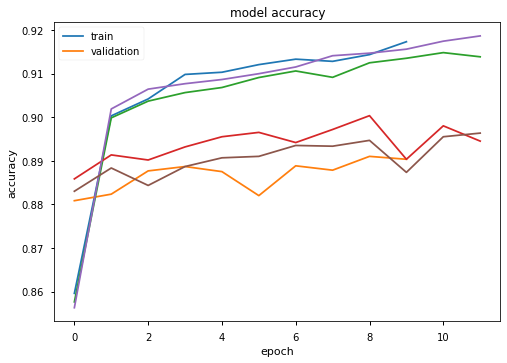

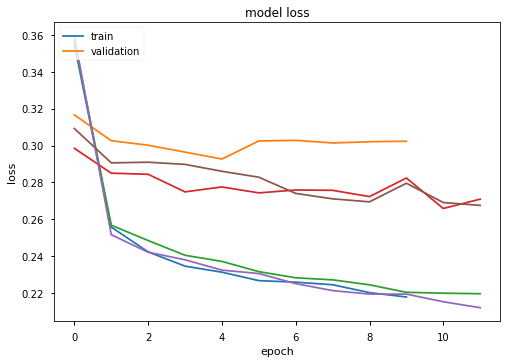

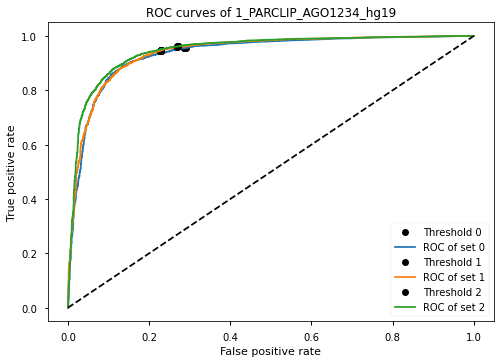

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 1_PARCLIP_AGO1234_hg19, with the average AUC of 0.9401417708333333 ([0.93478213 0.93893122 0.94671197]) across all three datasets.


In [7]:
# Plot accuracy, loss values and ROC.
if not os.path.exists("results/ROC"):
    os.makedirs("results/ROC")

scores_dict = {}
for protein in protein_list:
    average_score = np.zeros(3)
    print(protein)

    for training_set_number in range(3):
        # Load the model metrics generated with model fit.

        with open(
            "results/set_%s/%s/metrics" % (training_set_number, protein), "rb"
        ) as pickle_file:
            metrics = pickle.load(pickle_file, encoding="latin1")

            # Plot history for accuracy.
            plt.figure(1)
            plt.plot(metrics.history["acc"])
            plt.plot(metrics.history["val_acc"])
            plt.title("model accuracy")
            plt.ylabel("accuracy")
            plt.xlabel("epoch")
            plt.legend(["train", "validation"], loc="upper left")

            # Plot loss function history.
            plt.figure(2)
            plt.plot(metrics.history["loss"])
            plt.plot(metrics.history["val_loss"])
            plt.title("model loss")
            plt.ylabel("loss")
            plt.xlabel("epoch")
            plt.legend(["train", "validation"], loc="upper left")

        # Load model predictions.
        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "rb"
        ) as predictions_file:
            loaded_predictions = np.load(predictions_file)

            # Evaluate model performance.
            y_scores = loaded_predictions[:, 0:1]
            y_test = get_class(protein, "test", training_set_number)
            y_test = y_test[:, 0:1]

            # Find where the threshold is equal to 0.5
            score = roc_auc_score(y_test, y_scores)
            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
            thresholds = np.round(thresholds, 2)
            t_index = np.where(thresholds == 0.50)[0]

            # ROC plot
            plt.figure(3)
            plt.plot(
                fpr[t_index],
                tpr[t_index],
                "ok",
                label="Threshold {}".format(training_set_number),
            )
            plt.plot(fpr, tpr, label="ROC of set {}".format(training_set_number))

        average_score[training_set_number] = score

    scores_dict[protein] = np.mean(average_score)
    plt.figure(3)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"ROC curves of {protein}")
    plt.legend(loc="best")
    plt.savefig("results/ROC/{}.png".format(protein))
    plt.show()
    print(
        f"Plots of accuracy, loss function during traing and a ROC curve of model's predictions on {protein}, "
        f"with the average AUC of {np.mean(average_score)} ({average_score}) across all three datasets."
    )
    plt.close("all")



1_PARCLIP_AGO1234_hg19


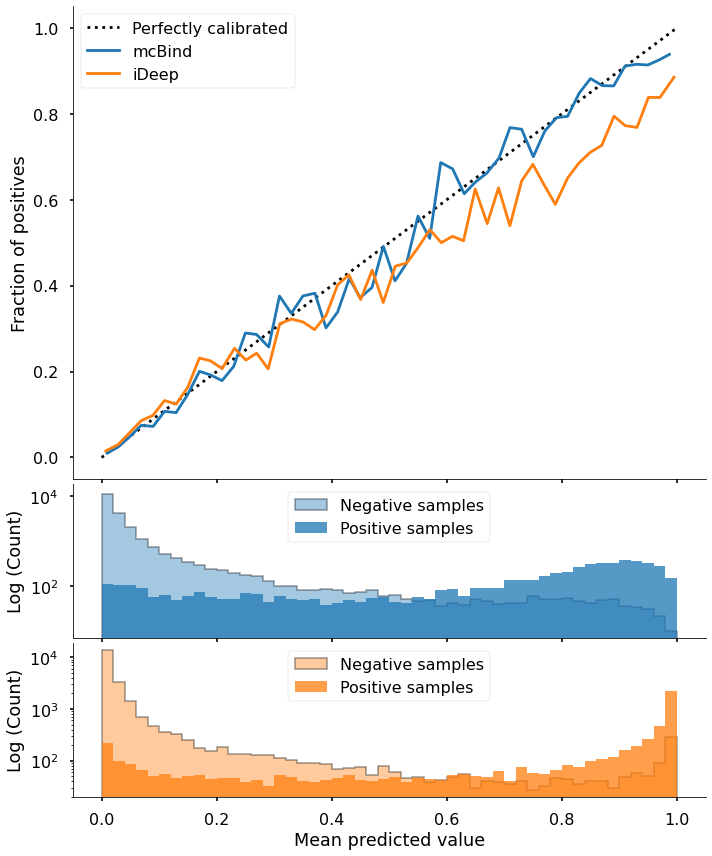

In [5]:
from sklearn.calibration import calibration_curve

if not os.path.exists("results/calibration_curves"):
    os.makedirs("results/calibration_curves")

for protein in protein_list:
    average_score = np.zeros(3)
    print(protein)
    complete_ideep_prediction = []
    y_scores = []
    total_y_test = []

    for training_set_number in range(3):
        # Load model predictions.
        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "rb"
        ) as predictions_file, open(
            "ideep_results/predictions%s/%s" % (training_set_number, protein), "r"
        ) as ideep_file:
            loaded_predictions = np.load(predictions_file, encoding="bytes")
            ideep_prediction = np.loadtxt(ideep_file, delimiter="\n", unpack=False)
            ideep_prediction = np.array(ideep_prediction)
            complete_ideep_prediction = np.append(
                complete_ideep_prediction, ideep_prediction
            )
            # Evaluate model performance.
            y_scores = np.append(y_scores, loaded_predictions[:, 1])
            y_test = get_class(protein, "test", training_set_number)
            total_y_test = np.append(total_y_test, y_test[:, 1])
    
    y_scores.flatten()
    total_y_test.flatten()
    complete_ideep_prediction.flatten()
    fraction_of_positives, mean_predicted_value = calibration_curve(
        total_y_test, y_scores, n_bins=50
    )
    ideep_frp, ideep_mpv = calibration_curve(
        total_y_test, complete_ideep_prediction, n_bins=50
    )

    style.use("seaborn-poster")
    fig = plt.figure(figsize=(10, 12))
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((5, 1), (3, 0), sharex=ax1)
    ax3 = plt.subplot2grid((5, 1), (4, 0), sharex=ax1)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(mean_predicted_value, fraction_of_positives, label="mcBind")
    ax1.plot(ideep_mpv, ideep_frp, label="iDeep")
    ax1.set_ylabel("Fraction of positives")
    ax1.legend(loc="upper left")

    ax2.hist(
        y_scores[total_y_test == 0],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        label="Negative samples",
        alpha=0.4,
        color="tab:blue",
        edgecolor="#04080d",
        linewidth=1.5,
    )
    ax2.hist(
        y_scores[total_y_test == 1],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        label="Positive samples",
        alpha=0.75,
        color="tab:blue",
    )

    ax3.hist(
        complete_ideep_prediction[total_y_test == 0],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        lw=2,
        label="Negative samples",
        alpha=0.4,
        color="tab:orange",
        edgecolor="black",
        linewidth=1.5,
    )
    ax3.hist(
        complete_ideep_prediction[total_y_test == 1],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        lw=2,
        label="Positive samples",
        alpha=0.75,
        color="tab:orange",
    )

    ax2.legend(loc="upper center")
    ax3.legend(loc="upper center")
    ax2.set_ylabel("Log (Count)")
    ax2.set_yscale("log")
    ax3.set_ylabel("Log (Count)")
    ax3.set_xlabel("Mean predicted value")
    ax3.set_yscale("log")

    top_max = max(ax2.get_ylim()[1], ax3.get_ylim()[1])

    ax2.set_ylim(top=top_max)
    ax3.set_ylim(top=top_max)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.03)

    for ax in [ax1, ax2, ax3]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.savefig("results/calibration_curves/{}_calibration_curve.png".format(protein))
    plt.show()
    plt.close()


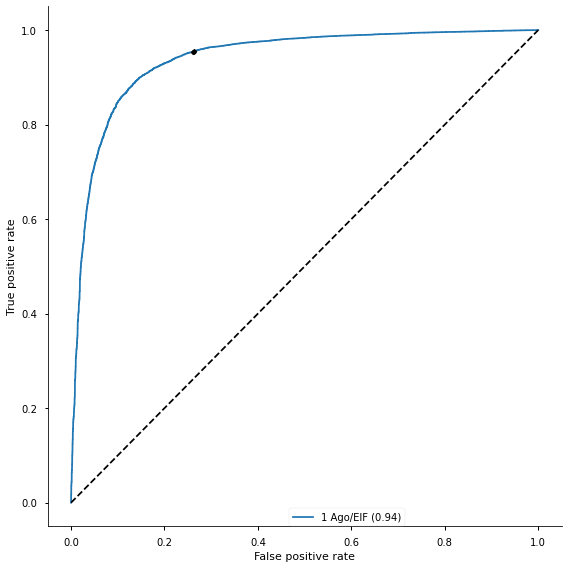

In [11]:
style.use("seaborn-notebook")

fig, ax = plt.subplots(figsize=(8, 8))
for protein, name in zip(protein_list, protein_names):
    complete_y_test = None
    complete_y_scores = None
    for training_set_number in range(3):
        # Load model predictions.
        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "rb"
        ) as predictions_file:
            loaded_predictions = np.load(predictions_file)

            if complete_y_test is not None:
                complete_y_test = np.append(
                    complete_y_test,
                    get_class(protein, "test", training_set_number)[:, 0:1],
                )
            else:
                complete_y_test = get_class(protein, "test", training_set_number)[
                    :, 0:1
                ]

            if complete_y_scores is not None:
                complete_y_scores = np.append(
                    complete_y_scores, loaded_predictions[:, 0:1]
                )
            else:
                complete_y_scores = loaded_predictions[:, 0:1]
    fpr, tpr, thresholds = roc_curve(complete_y_test, complete_y_scores)
    # auc[name] = roc_auc_score(complete_y_test, complete_y_scores)

    thresholds = np.round(thresholds, 2)
    t_index = np.where(thresholds == 0.50)[0]
    ax.plot(fpr, tpr, label=f"{name} ({round(scores_dict[protein], 2)})")
    ax.plot(fpr[t_index], tpr[t_index], ".k")

ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
handles, labels = ax.get_legend_handles_labels()

# sort both labels and handles by labels
auc, labels, handles = zip(
    *sorted(zip(scores_dict.values(), labels, handles), key=lambda t: t[0])
)
ax.legend(handles[::-1], labels[::-1], loc=[0.47, 0], ncol=2)
plt.tight_layout()
plt.savefig("results/combined_ROC.svg")
plt.show()


In [12]:
scores_dict

{'1_PARCLIP_AGO1234_hg19': 0.9401417708333333}

In [13]:
def highlight_max(s):
    """Marks the series in bold."""
    is_max = s == s.max()
    return ['font-weight:bold' if v else '' for v in is_max]

def latex_highlight(x):
    is_max = x == x.max()
    return [f'\\textbf{{{np.round(val, 2)}}}' if v else np.round(val, 2) for val, v in zip(x, is_max)]

ionmf = [0.9, 0.69, 0.82, 0.81, 0.65, 0.84, 0.89, 0.81, 0.66, 0.94, 0.93, 0.82, 0.59, 0.92, 0.91,
         0.62, 0.61, 0.76, 0.63, 0.71, 0.96, 0.77, 0.91, 0.58, 0.84, 0.86, 0.61, 0.87, 0.8, 0.67, 0.66]
ideep = [0.93668944, 0.76282461, 0.94159092, 0.94483924, 0.76107508, 0.95504916,
         0.97001479, 0.96485094, 0.76609511, 0.9469512,  0.9469512,  0.9525081,
         0.94539888, 0.98648477, 0.95614971, 0.94825049, 0.96873706, 0.84875831,
         0.82395875, 0.82983874, 0.97112416, 0.88624311, 0.98298004, 0.96877799,
         0.92754448, 0.97679184, 0.91218175, 0.94829456, 0.9227082,  0.95288192,
         0.94209036]

table_data = {'mcBind': scores_dict, 'iDeep': ideep, 'iONMF': ionmf}

table = pd.DataFrame(table_data, index=protein_list)

d1 = np.subtract(new, ideep)
d2 = np.subtract(new, ionmf)

n1 = sum(1 for number in d1 if number > 0)
n2 = sum(1 for number in d2 if number > 0)

print("Mean difference with iDeep is %s " % (np.mean(d1)))
print("Number of proteins for which our model is better: %s " % (n1))
print("Mean difference with iONMF is %s " % (np.mean(d2)))
print("Number of proteins for which our model is better: %s " % (n2))


with pd.option_context('display.precision', 2):
    html = (table.style.apply(highlight_max, axis=1))
latex_table = table.apply(latex_highlight, axis=1, result_type='expand')

# print(latex_table.to_latex(escape=False))
html

ValueError: could not broadcast input array from shape (31) into shape (1)